# Robot Perception Final
## Opimizing location estimation from coincident microphone pair

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('video')
import subprocess
import glob

In [2]:
class mic:
        
    def __init__(self, name, xpos, ypos, angle):
        self.name = name
        self.xpos = xpos
        self.ypos = ypos
        self.angle = angle

    def add_noise_to_signal(self, signal, noise_level):
        # adds environmental noise to the signal.
        noise = np.random.normal(0, noise_level, len(signal))
        return signal + noise
        
    def getAngleGainVectors(self):
        radians = np.arange(0,2*np.pi,2*np.pi/360)
        return .5*(1 + np.cos(radians-self.angle)), radians
        
        
    def getGainFromSource(self, xpos, ypos, noise_level = 0, graph=True): # determines angle
        
        # get angle (radians) from source
        source_angle = np.arctan2(ypos-self.ypos,xpos-self.xpos) % (2*np.pi)
        
        # get difference in source and self angles
        angle_diff = self.angle-source_angle
        
        #calculate gain from cardioid polar pattern
        radians = np.arange(0,2*np.pi,2*np.pi/360)
        gains = .5*(1 + np.cos(radians-self.angle)) # cardioid with gain of 1 at front and 0 at back
        gains = self.add_noise_to_signal(gains, noise_level)

        if graph:
            plt.polar(radians, gains)
            plt.polar(source_angle, 1, 'o')
            plt.show()
        
        # get index of gains corresponding to DOA
        angle_index = np.abs(radians - source_angle).argmin()
        
        # calculate distance
        distance = ((ypos-self.ypos)**2 + (xpos-self.xpos)**2) **.5
        if graph:
            print('distance', distance)
        
        # scale gain by distance, 1/r^2
        dist_coeff = 1/(distance**2)
        if graph:
            print('dist_coeff', dist_coeff)
        gains*=dist_coeff
        
        return gains[angle_index]
    
    def getDirectionFromGains(self, gain1, gain2, mic2, graph = True): #returns direction in radians of source
        # assumes angle between microphones is pi/2        
        # calculate gain ratios between 2 cardioids at pi/2
        gains1, radians = self.getAngleGainVectors()
        gains2, radians = mic2.getAngleGainVectors()
        xy_gain_ratios = (gains1/gains2)[:180]
        
        # get index of gain ratios
        index = np.abs(xy_gain_ratios - gain1/gain2).argmin()
        angle = index*np.pi/180
        
        #plotting
        if graph:
            
            plt.polar(radians, gains1)
            plt.polar(radians, gains2)
            #plt.polar(radians[:180],xy_gain_ratios/5)
            plt.polar(angle % (2*np.pi),1,'o')
            plt.title('Dot for estimated location')
            plt.show()
        
        #index is angle in degrees
        return angle
    
    def getDistance(self, angle, gain):
        # given gain and angle, return the distance from the source
        mic_gains, radians = self.getAngleGainVectors()
        
        # turn angle into index(degrees) for gain
        index = np.abs(radians-angle).argmin()
        
        # reverse of mic_gain = gain * (1/r**2) (calculate r)
        r = ( mic_gains[index] / gain ) ** .5
        
        return r

    def introduceDiscretizationError(self, gain, lookup_table):
        # Simulate discretization error by finding the closest value in the lookup table
        quantized_gain = lookup_table[np.abs(lookup_table - gain).argmin()]
        return quantized_gain
    
    def adjust_angle(self, optimal_angle):
        """
        Adjusts the microphone's angle to the optimal_angle calculated.
        """
        self.angle = optimal_angle % (2 * np.pi)

    # Function to plot microphones in cardioid pattern in the workspace
    def plot_initial_microphones(mics):
        plt.figure(figsize=(8, 8))

        for i, mic in enumerate(mics):
            # Plot the microphone's original orientation with a cardioid pattern
            angles = np.linspace(0, 2 * np.pi, 100)
            cardioid_x = 0.5 * (1 + np.cos(angles)) * np.cos(angles + mic.angle) + mic.xpos
            cardioid_y = 0.5 * (1 + np.cos(angles)) * np.sin(angles + mic.angle) + mic.ypos
            plt.plot(cardioid_x, cardioid_y, label=f'{mic.name} Original Pattern')

        plt.xlim(-4, 7)
        plt.ylim(-4, 7)
        plt.xlabel('X position')
        plt.ylabel('Y position')
        plt.title('Initial Microphone Configuration')
        plt.grid(True)
        plt.legend()
        plt.show()


In [3]:
def optimize_sensor_angles(mics, sources):
    """
    Optimizes sensor by picking the closest source to each microphone and adjusting the angle of
    the microphone to place the source at a 45-degree angle from the microphone's axis, maintaining a 90-degree XY configuration.
    """
    for i, mic in enumerate(mics):
        # Find the nearest source to the microphone
        nearest_source = min(sources, key=lambda s: np.hypot(s[0] - mic.xpos, s[1] - mic.ypos))
        # Calculate the angle to the nearest source
        source_angle = np.arctan2(nearest_source[1] - mic.ypos, nearest_source[0] - mic.xpos)
        
        # Adjust the microphone angle to place the source at a 45-degree angle 
        # from the microphone's axis, maintaining a 90-degree XY configuration.
        if i % 2 == 0:  # Assuming the first mic is on the left
            optimal_angle = source_angle - np.pi/4
        else:  # Assuming the second mic is on the right
            optimal_angle = source_angle + np.pi/4
        
        # Adjust the microphone angle
        mic.adjust_angle(optimal_angle)
        rotation_needed = source_angle - np.pi/4

        # Print the source angle and the optimal angle for each microphone
        print(f"Mic {i+1}: Source Angle = {np.degrees(source_angle):.2f} degrees, Rotation Needed = {np.degrees(rotation_needed):.2f} degrees")

# Note: Ensure that the Mic class has a method 'adjust_angle' to change the angle attribute.


In [23]:
def simulate_environment(mics, source, index, noise_level=0):
    plt.figure(figsize=(8, 8))

    # Calculate midpoint for the 45-degree line between mics if they are positioned at the same point
    midpoint = (0, 0)  # Setting the midpoint to (0, 0) for overlapping cardioid patterns

    # simulate microphone gains
    gain1 = mics[0].getGainFromSource(source[0],source[1], graph=False)
    gain2 = mics[1].getGainFromSource(source[0],source[1], graph=False)
    
    # calculate sound source location using microphone gains
    source_angle =  mic1.getDirectionFromGains(gain1,gain2,mic2, graph=False)
    
    for i, mic in enumerate(mics):

        # Adjust the microphone angle to maintain a 45-degree angle with the source
        mic.angle = source_angle + (-1)**i * np.radians(45)  # Alternate between adding and subtracting 45 degrees
        
        # Draw a line representing the 45-degree angle between the microphone and the source
        line_45_length = 1.5  # Length of the 45-degree line
        angle_45 = source_angle + (-1)**i * np.radians(45)
        plt.plot([mic.xpos, mic.xpos + line_45_length * np.cos(angle_45)],
                 [mic.ypos, mic.ypos + line_45_length * np.sin(angle_45)],
                 'r--', label=f'Fixed Degree Line Mic {i+1}')
        
        # Plot the microphone's orientation with a cardioid pattern
        angles = np.linspace(0, 2 * np.pi, 100)
        cardioid_x = 0.5 * (1 + np.cos(angles)) * np.cos(angles + mic.angle) + midpoint[0]
        cardioid_y = 0.5 * (1 + np.cos(angles)) * np.sin(angles + mic.angle) + midpoint[1]
        plt.plot(cardioid_x, cardioid_y, label=f'Mic {i+1} Pattern')

        # Draw a line representing the 0-degree (direct) angle to the nearest source
        line_0_length = 2.5  # Length of the 0-degree line
        plt.plot([mic.xpos, mic.xpos + line_0_length * np.cos(source_angle)],
                 [mic.ypos, mic.ypos + line_0_length * np.sin(source_angle)],
                 'b-', label=f'Optimization Line' if i == 0 else '')

    # Label the microphones with padding
    label_padding_x = 1.2
    label_padding_y = 1.2
    plt.text(mics[0].xpos - label_padding_x, mics[0].ypos + label_padding_y, 'Mic 1', fontsize=12, ha='left', va='bottom')
    plt.text(mics[1].xpos + label_padding_x, mics[1].ypos - label_padding_y, 'Mic 2', fontsize=12, ha='right', va='bottom')

    # Plot the positions of the source
    #for i, source in enumerate(source):
    plt.plot(source[0],source[1], 'o', label='Source')

    plt.legend()
    plt.xlim(-4, 7)
    plt.ylim(-4, 7)
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.title('Simulation Environment')
    plt.grid(True)
    plt.savefig(os.getcwd()+"/file%02d.png" % index)
    plt.close()

## Simulation with Optimization Example

In [24]:
# Create microphones, mic1 being the left and mic2 being the right in the XY configuration
mic1 = mic('Mic1', 0, 0, np.pi/2)  # Initial angle set to 0 degrees (pointing upwards)
mic2 = mic('Mic2', 0, 0, 0) 

source_locations_x = np.arange(6,0,-.1)
source_locations_y = np.arange(-2,4,.1)

sources = [(1.5, 4), (-2, 6)]
optimize_sensor_angles([mic1, mic2], sources)

# Simulate environment showing the optimized angles
for i in range(len(source_locations_x)):
    simulate_environment([mic1, mic2], (source_locations_x[i],source_locations_y[i]),i)

Mic 1: Source Angle = 69.44 degrees, Rotation Needed = 24.44 degrees
Mic 2: Source Angle = 69.44 degrees, Rotation Needed = 24.44 degrees


/var/folders/jd/1_gd183x3t593pby7j1spmr00000gn/T/ipykernel_42586/892573500.py:58: RuntimeWarning: divide by zero encountered in true_divide
  xy_gain_ratios = (gains1/gains2)[:180]


In [25]:
# Run to turn saved figures into a video
subprocess.call([
    'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
    'target_tracking.mp4'
])
for file_name in glob.glob("*.png"):
    os.remove(file_name)

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --di

## Example use of `getGainFromSource`

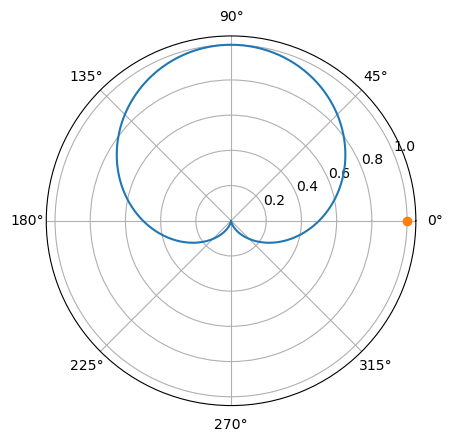

distance 1.0
dist_coeff 1.0
gain: 0.5


In [7]:
# mic is at the origin with an angle of 0
mic1 = mic('mic1',0,0,np.pi/2)

gain = mic1.getGainFromSource(1, 0) # source is at position x=0,y=1
print('gain:',gain)

## Example use of `getDirectionFromGains`

/var/folders/jd/1_gd183x3t593pby7j1spmr00000gn/T/ipykernel_42586/892573500.py:58: RuntimeWarning: divide by zero encountered in true_divide
  xy_gain_ratios = (gains1/gains2)[:180]


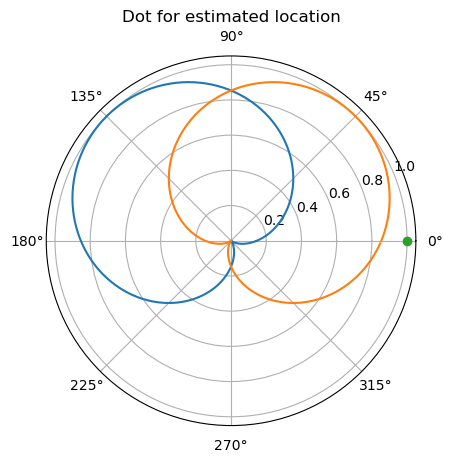

Estimated angle of source in radians: 0.0
Estimated distance of source: 1.0


In [8]:
mic1 = mic('mic1',0,0,3*np.pi/4)
mic2 = mic('mic2',0,0,np.pi/4)

# arbitrary sound source location
xpos = 1
ypos = 0

# simulation: calculate the signal gains given the source location
gain1 = mic1.getGainFromSource(xpos,ypos,graph=False)
gain2 = mic2.getGainFromSource(xpos,ypos,graph=False)

# prediction: estimate the sound source angle given the signal gains
angle =  mic1.getDirectionFromGains(gain1,gain2,mic2)
print("Estimated angle of source in radians:",angle)

# prediction: estimate the sounde source distance given the angle and source loudness
dist = mic1.getDistance(angle,gain1)
print('Estimated distance of source:',dist)

## Example use of `introduceDiscretizationError`

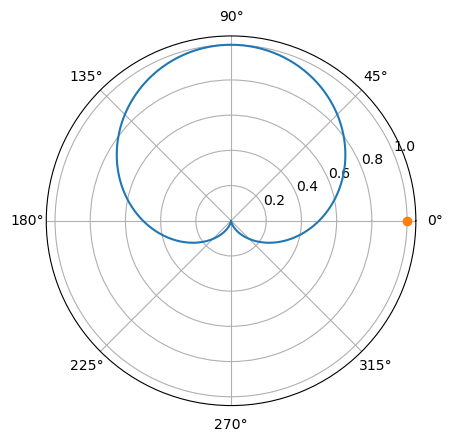

distance 1.0
dist_coeff 1.0
Original gain: 0.5
Quantized gain: 0.4994994994994995


In [9]:
# mic is at the origin with an angle of 0
mic1 = mic('mic1', 0, 0, np.pi/2)

# Define a lookup table for gain values
resolution = 1000  # Adjust the resolution as needed
lookup_table = np.linspace(0, 1, resolution)

# Simulate discretization error for gain using the lookup table
gain = mic1.getGainFromSource(1, 0)  # Replace with actual values
quantized_gain = mic1.introduceDiscretizationError(gain, lookup_table)
print('Original gain:', gain)
print('Quantized gain:', quantized_gain)

In [10]:
# Notes
# assumes the source comes from the front 180 degrees of the x-y system